In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin

# Define the functions and classes
def compute_compact_degree(cluster_labels, true_labels):
    n_total = len(cluster_labels)
    if n_total == 0:
        return 0
    unique_classes = np.unique(true_labels)
    compactness = 0
    for class_label in unique_classes:
        class_count = np.sum(true_labels == class_label)
        if class_count > 0:
            compactness += (class_count / n_total) * np.log(class_count / n_total)
    return -compactness

def split_cluster(data, n_clusters=2):
    if len(data) < n_clusters:
        return np.zeros(len(data)), np.mean(data, axis=0).reshape(1, -1)
    
    kmeans = KMeans(n_clusters=n_clusters)
    sub_cluster_labels = kmeans.fit_predict(data)
    return sub_cluster_labels, kmeans.cluster_centers_

def merge_clusters(X, cluster_labels, target_num_clusters):
    unique_clusters = np.unique(cluster_labels)
    if len(unique_clusters) <= target_num_clusters:
        return cluster_labels

    cluster_centers = np.vstack([X[cluster_labels == i].mean(axis=0) for i in unique_clusters])
    distances = pairwise_distances(cluster_centers)
    np.fill_diagonal(distances, np.inf)
    
    while len(np.unique(cluster_labels)) > target_num_clusters:
        closest_pair = np.unravel_index(np.argmin(distances), distances.shape)
        merge_target = unique_clusters[closest_pair[0]]
        merge_source = unique_clusters[closest_pair[1]]
        cluster_labels[cluster_labels == merge_source] = merge_target
        
        unique_clusters = np.unique(cluster_labels)
        if len(unique_clusters) <= target_num_clusters:
            break
        
        cluster_centers = np.vstack([X[cluster_labels == i].mean(axis=0) for i in unique_clusters])
        distances = pairwise_distances(cluster_centers)
        np.fill_diagonal(distances, np.inf)
    
    return cluster_labels

def cssc_algorithm_two_clusters(X, y, alpha=0.7, max_iter=100):
    kmeans = KMeans(n_clusters=2)
    cluster_labels = kmeans.fit_predict(X)
    cluster_centers = kmeans.cluster_centers_
    
    for iteration in range(max_iter):
        new_cluster_labels = np.copy(cluster_labels)
        compact_degrees = []
        
        for cluster_id in np.unique(cluster_labels):
            cluster_indices = np.where(cluster_labels == cluster_id)[0]
            cluster_data = X[cluster_indices]
            cluster_true_labels = y[cluster_indices]
            
            compact_degree = compute_compact_degree(cluster_data, cluster_true_labels)
            compact_degrees.append(compact_degree)
            
            if compact_degree < 1:
                sub_cluster_labels, sub_centers = split_cluster(cluster_data)
                new_cluster_labels[cluster_indices] = sub_cluster_labels + new_cluster_labels.max() + 1
        
        new_cluster_labels = merge_clusters(X, new_cluster_labels, 2)
        
        if np.array_equal(cluster_labels, new_cluster_labels):
            break
        
        cluster_labels = new_cluster_labels
        cluster_centers = np.vstack([X[cluster_labels == i].mean(axis=0) for i in np.unique(cluster_labels)])
        
        kmeans = KMeans(n_clusters=2, init=cluster_centers, n_init=1)
        cluster_labels = kmeans.fit_predict(X)
    
    return cluster_labels, cluster_centers

def semi_supervised_cssc_two_clusters(X_labeled, y_labeled, X_unlabeled, alpha=0.7, max_iter=100):
    X_combined = np.vstack((X_labeled, X_unlabeled))
    y_combined = np.hstack((y_labeled, -np.ones(X_unlabeled.shape[0])))
    
    cluster_labels, cluster_centers = cssc_algorithm_two_clusters(X_combined, y_combined, alpha, max_iter)
    
    return cluster_labels, cluster_centers

def assign_cluster_labels(cluster_labels, true_labels):
    assigned_labels = np.zeros_like(cluster_labels)
    unique_clusters = np.unique(cluster_labels)
    cluster_label_mapping = {}
    
    for cluster_id in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_true_labels = true_labels[cluster_indices]
        most_common_label = np.argmax(np.bincount(cluster_true_labels[cluster_true_labels >= 0].astype(int)))
        assigned_labels[cluster_indices] = most_common_label
        cluster_label_mapping[cluster_id] = most_common_label
    
    return assigned_labels, cluster_label_mapping

class CSSCClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0.7, max_iter=100):
        self.alpha = alpha
        self.max_iter = max_iter
        self.cluster_centers_ = None
        self.cluster_label_mapping_ = None

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        self.cluster_labels_, self.cluster_centers_ = semi_supervised_cssc_two_clusters(X_labeled, y_labeled, X_unlabeled, self.alpha, self.max_iter)
        self.assigned_labels_, self.cluster_label_mapping_ = assign_cluster_labels(self.cluster_labels_, np.hstack((y_labeled, -np.ones(X_unlabeled.shape[0]))))
        return self

    def predict(self, X):
        if self.cluster_centers_ is None:
            raise ValueError("Model has not been fitted yet")
        
        distances = pairwise_distances(X, self.cluster_centers_)
        cluster_indices = np.argmin(distances, axis=1)
        predicted_labels = np.vectorize(self.cluster_label_mapping_.get)(cluster_indices)
        return predicted_labels




# Example usage

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

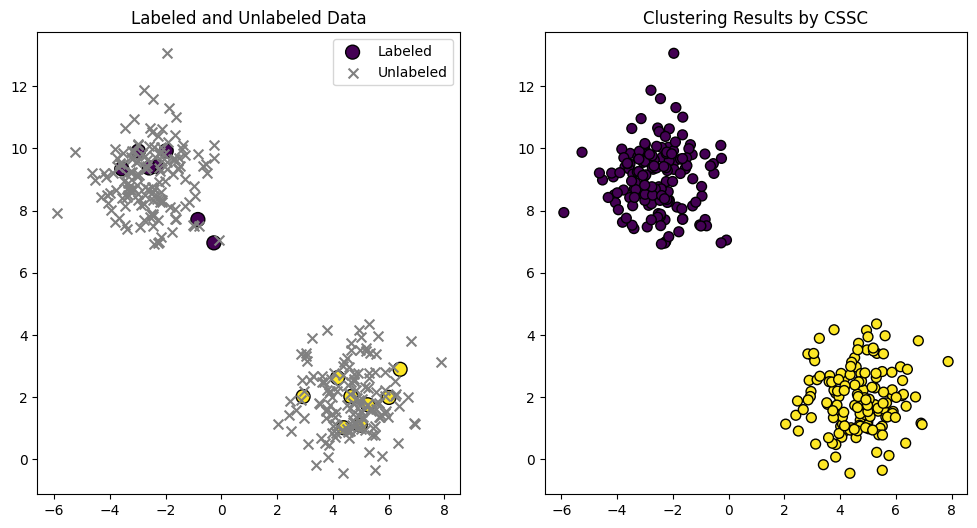

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin



# Create a dummy dataset
X, y = make_blobs(n_samples=300, centers=2, cluster_std=1.05, random_state=42)

# Split the data into labeled and unlabeled sets
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.95, stratify=y, random_state=42)

# Instantiate the classifier and fit it to the data
cssc_clf = CSSCClassifier(alpha=0.7, max_iter=100)
cssc_clf.fit(X_labeled, y_labeled, X_unlabeled)

# Predict the labels for the entire dataset
predicted_labels = cssc_clf.predict(X)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, marker='o', edgecolor='k', s=100, label='Labeled')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='gray', marker='x', edgecolor='k', s=50, label='Unlabeled')
plt.title('Labeled and Unlabeled Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, marker='o', edgecolor='k', s=50)
plt.title('Clustering Results by CSSC')

plt.show()


# Works fine!

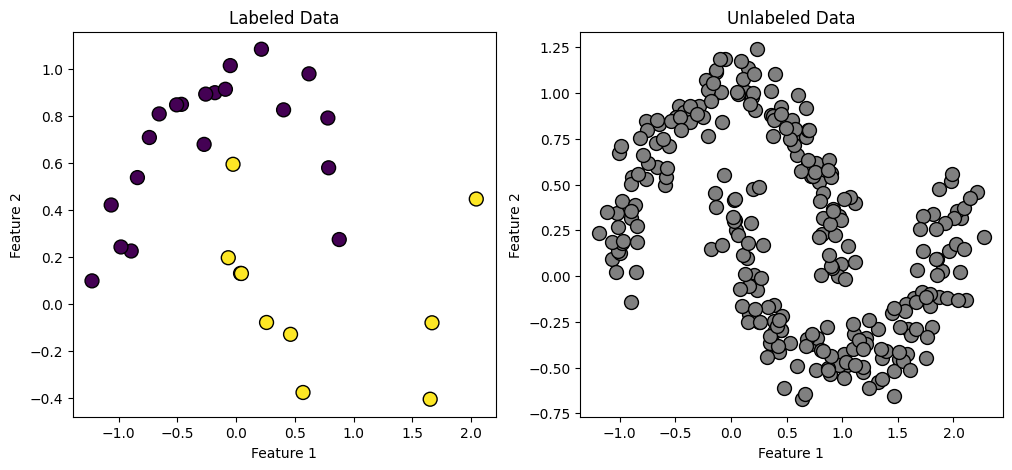

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

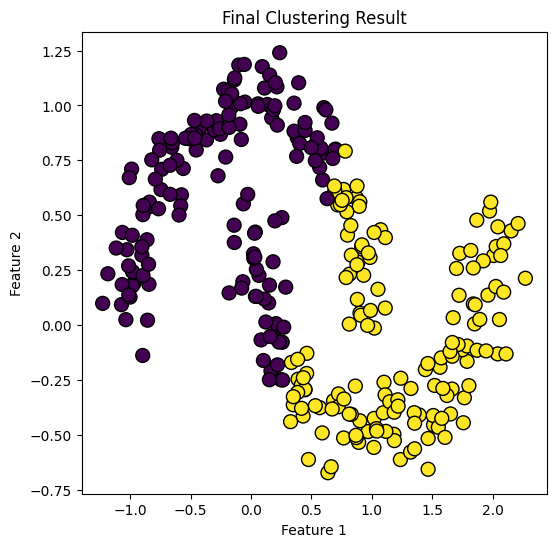

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, ClassifierMixin

# Define the functions and classes
def compute_compact_degree(cluster_labels, true_labels):
    n_total = len(cluster_labels)
    if n_total == 0:
        return 0
    unique_classes = np.unique(true_labels)
    compactness = 0
    for class_label in unique_classes:
        class_count = np.sum(true_labels == class_label)
        if class_count > 0:
            compactness += (class_count / n_total) * np.log(class_count / n_total)
    return -compactness

def split_cluster(data, n_clusters=2):
    if len(data) < n_clusters:
        return np.zeros(len(data)), np.mean(data, axis=0).reshape(1, -1)
    
    kmeans = KMeans(n_clusters=n_clusters)
    sub_cluster_labels = kmeans.fit_predict(data)
    return sub_cluster_labels, kmeans.cluster_centers_

def merge_clusters(X, cluster_labels, target_num_clusters):
    unique_clusters = np.unique(cluster_labels)
    if len(unique_clusters) <= target_num_clusters:
        return cluster_labels

    cluster_centers = np.vstack([X[cluster_labels == i].mean(axis=0) for i in unique_clusters])
    distances = pairwise_distances(cluster_centers)
    np.fill_diagonal(distances, np.inf)
    
    while len(np.unique(cluster_labels)) > target_num_clusters:
        closest_pair = np.unravel_index(np.argmin(distances), distances.shape)
        merge_target = unique_clusters[closest_pair[0]]
        merge_source = unique_clusters[closest_pair[1]]
        cluster_labels[cluster_labels == merge_source] = merge_target
        
        unique_clusters = np.unique(cluster_labels)
        if len(unique_clusters) <= target_num_clusters:
            break
        
        cluster_centers = np.vstack([X[cluster_labels == i].mean(axis=0) for i in unique_clusters])
        distances = pairwise_distances(cluster_centers)
        np.fill_diagonal(distances, np.inf)
    
    return cluster_labels

def cssc_algorithm_two_clusters(X, y, alpha=0.7, max_iter=100):
    kmeans = KMeans(n_clusters=2)
    cluster_labels = kmeans.fit_predict(X)
    cluster_centers = kmeans.cluster_centers_
    
    for iteration in range(max_iter):
        new_cluster_labels = np.copy(cluster_labels)
        compact_degrees = []
        
        for cluster_id in np.unique(cluster_labels):
            cluster_indices = np.where(cluster_labels == cluster_id)[0]
            cluster_data = X[cluster_indices]
            cluster_true_labels = y[cluster_indices]
            
            compact_degree = compute_compact_degree(cluster_data, cluster_true_labels)
            compact_degrees.append(compact_degree)
            
            if compact_degree < 1:
                sub_cluster_labels, sub_centers = split_cluster(cluster_data)
                new_cluster_labels[cluster_indices] = sub_cluster_labels + new_cluster_labels.max() + 1
        
        new_cluster_labels = merge_clusters(X, new_cluster_labels, 2)
        
        if np.array_equal(cluster_labels, new_cluster_labels):
            break
        
        cluster_labels = new_cluster_labels
        cluster_centers = np.vstack([X[cluster_labels == i].mean(axis=0) for i in np.unique(cluster_labels)])
        
        kmeans = KMeans(n_clusters=2, init=cluster_centers, n_init=1)
        cluster_labels = kmeans.fit_predict(X)
    
    return cluster_labels, cluster_centers

def semi_supervised_cssc_two_clusters(X_labeled, y_labeled, X_unlabeled, alpha=0.7, max_iter=100):
    X_combined = np.vstack((X_labeled, X_unlabeled))
    y_combined = np.hstack((y_labeled, -np.ones(X_unlabeled.shape[0])))
    
    cluster_labels, cluster_centers = cssc_algorithm_two_clusters(X_combined, y_combined, alpha, max_iter)
    
    return cluster_labels, cluster_centers

def assign_cluster_labels(cluster_labels, true_labels):
    assigned_labels = np.zeros_like(cluster_labels)
    unique_clusters = np.unique(cluster_labels)
    cluster_label_mapping = {}
    
    for cluster_id in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster_id)[0]
        cluster_true_labels = true_labels[cluster_indices]
        most_common_label = np.argmax(np.bincount(cluster_true_labels[cluster_true_labels >= 0].astype(int)))
        assigned_labels[cluster_indices] = most_common_label
        cluster_label_mapping[cluster_id] = most_common_label
    
    return assigned_labels, cluster_label_mapping

class CSSCClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0.7, max_iter=100):
        self.alpha = alpha
        self.max_iter = max_iter
        self.cluster_centers_ = None
        self.cluster_label_mapping_ = None

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        self.cluster_labels_, self.cluster_centers_ = semi_supervised_cssc_two_clusters(X_labeled, y_labeled, X_unlabeled, self.alpha, self.max_iter)
        self.assigned_labels_, self.cluster_label_mapping_ = assign_cluster_labels(self.cluster_labels_, np.hstack((y_labeled, -np.ones(X_unlabeled.shape[0]))))
        return self

    def predict(self, X):
        if self.cluster_centers_ is None:
            raise ValueError("Model has not been fitted yet")
        
        distances = pairwise_distances(X, self.cluster_centers_)
        cluster_indices = np.argmin(distances, axis=1)
        predicted_labels = np.vectorize(self.cluster_label_mapping_.get)(cluster_indices)
        return predicted_labels

# Create a dummy moon dataset
X, y = make_moons(n_samples=300, noise=0.1, random_state=42)

# Split the data into labeled and unlabeled sets
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.9, random_state=42)

# Plot the labeled and unlabeled data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title('Labeled Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c='gray', marker='o', edgecolor='k', s=100)
plt.title('Unlabeled Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.show()

# Fit the CSSC algorithm to the data
cssc = CSSCClassifier(alpha=0.7, max_iter=100)
cssc.fit(X_labeled, y_labeled, X_unlabeled)

# Predict the labels for the entire dataset
y_pred = cssc.predict(X)

# Plot the final clustering result
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title('Final Clustering Result')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


# Doesn't work fine! 